In [35]:
import re
import numpy as np

# Load Pre-trained Word2vec Model
from gensim.models import word2vec

# Data visualization
from matplotlib import pyplot as plt
%matplotlib inline

# CNN
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras import losses

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout
from keras.models import Model, Sequential

## 1. Load Data

In [9]:
TRAIN_FILE = 'data/ratings_train.txt'
TEST_FILE = 'data/ratings_test.txt'

In [65]:
# Read data
train_reviews = []
with open(TRAIN_FILE, 'r') as f:
    next(f) # header skip
    for line in f.readlines():
        _, review, label = line.strip().split('\t')
        train_reviews.append((review.strip(), label.strip()))
        
test_reviews = []        
with open(TEST_FILE, 'r') as f:
    next(f) # header skip
    for line in f.readlines():
        _, review, label = line.strip().split('\t')
        test_reviews.append((review.strip(), label.strip()))

## 2. Preprocessing

In [17]:
from konlpy.tag import Twitter
twi_tagger = Twitter()

def tokenizer(doc):
    tokens = ['/'.join(t) for t in twi_tagger.pos(doc, norm=True, stem=True)]
    return tokens

In [18]:
%%time
train_reviews = [(tokenizer(review), int(label)) for review, label in train_reviews]
test_reviews = [(tokenizer(review), int(label)) for review, label in test_reviews]

CPU times: user 3min 38s, sys: 2.1 s, total: 3min 40s
Wall time: 3min 36s


In [19]:
train_reviews[:5]

[(['아/Exclamation',
   '더빙/Noun',
   '../Punctuation',
   '진짜/Noun',
   '짜증/Noun',
   '나다/Verb',
   '목소리/Noun'],
  0),
 (['흠/Noun',
   '.../Punctuation',
   '포스터/Noun',
   '보고/Noun',
   '초딩/Noun',
   '영화/Noun',
   '줄/Noun',
   '..../Punctuation',
   '오버/Noun',
   '연기/Noun',
   '조차/Josa',
   '가볍다/Adjective',
   '않다/Verb'],
  1),
 (['너무/Noun',
   '재/Noun',
   '밓었/Noun',
   '다/Josa',
   '그래서/Adverb',
   '보다/Verb',
   '추천/Noun',
   '하다/Verb'],
  0),
 (['교도소/Noun',
   '이야기/Noun',
   '구먼/Noun',
   '../Punctuation',
   '솔직하다/Adjective',
   '재미/Noun',
   '는/Josa',
   '없다/Adjective',
   '../Punctuation',
   '평점/Noun',
   '조정/Noun'],
  0),
 (['사이몬페그/Noun',
   '의/Josa',
   '익살/Noun',
   '스런/Josa',
   '연기/Noun',
   '가/Josa',
   '돋보이다/Verb',
   '영화/Noun',
   '!/Punctuation',
   '스파이더맨/Noun',
   '에서/Josa',
   '늙다/Verb',
   '보이다/Verb',
   '하다/Verb',
   '크다/Verb',
   '스틴/Noun',
   '던스트/Noun',
   '가/Josa',
   '너무나/Noun',
   '도/Josa',
   '이쁘다/Adjective',
   '보이다/Verb'],
  1)]

In [55]:
X_train = [review for review, _ in train_reviews] # Review Sequence of Train data
y_train = [label for _, label in train_reviews] # Label of Train data
X_test = [review for review, _ in test_reviews] # Review Sequence of Test data
y_test = [label for _, label in test_reviews] # Label of Test data

In [56]:
X_train[:3]

[['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증/Noun',
  '나다/Verb',
  '목소리/Noun'],
 ['흠/Noun',
  '.../Punctuation',
  '포스터/Noun',
  '보고/Noun',
  '초딩/Noun',
  '영화/Noun',
  '줄/Noun',
  '..../Punctuation',
  '오버/Noun',
  '연기/Noun',
  '조차/Josa',
  '가볍다/Adjective',
  '않다/Verb'],
 ['너무/Noun',
  '재/Noun',
  '밓었/Noun',
  '다/Josa',
  '그래서/Adverb',
  '보다/Verb',
  '추천/Noun',
  '하다/Verb']]

### Load pre-trained Word2vec Model

In [57]:
model_file = 'w2v/300dim_1minwords_4context_twi' 
w2v = word2vec.Word2Vec.load(model_file).wv

In [58]:
w2v.index2word[:20] # word2vec 모델안에 저장된 단어 리스트 (빈도 순으로 내림차 정렬)

['./Punctuation',
 '영화/Noun',
 '하다/Verb',
 '이/Josa',
 '보다/Verb',
 '의/Josa',
 '../Punctuation',
 '에/Josa',
 '가/Josa',
 '을/Josa',
 '도/Josa',
 '.../Punctuation',
 '은/Josa',
 '들/Suffix',
 ',/Punctuation',
 '는/Josa',
 '없다/Adjective',
 '를/Josa',
 '있다/Adjective',
 '좋다/Adjective']

In [59]:
# 전체 단어 갯수
len(w2v.index2word)

55824

In [66]:
w2v['영화/Noun']

array([  1.15485497e-01,  -9.72887222e-03,  -5.56833856e-03,
         1.75525676e-02,  -6.77212402e-02,   1.92349672e-01,
        -1.34603202e-01,  -1.91257656e-01,   1.58908665e-01,
        -4.98501696e-02,   1.13174751e-01,   7.07398355e-02,
        -1.50875881e-01,  -1.18156578e-02,  -1.69227123e-01,
         9.30930376e-02,  -1.14399679e-01,  -1.48578174e-02,
         8.34368765e-02,  -2.13713288e-01,  -1.65826097e-01,
        -8.56175050e-02,   6.88526630e-02,  -4.82723908e-03,
         5.24557121e-02,   1.27921864e-01,  -1.63795203e-01,
         1.46113053e-01,  -2.27731720e-01,   7.80711919e-02,
         5.02348365e-03,  -5.55018410e-02,   2.47064799e-01,
         1.34310266e-03,  -5.46680354e-02,  -1.31333932e-01,
        -1.93441600e-01,   2.58420229e-01,   2.56266713e-01,
        -1.17789015e-01,   3.42658699e-01,   8.53507221e-02,
        -8.06954503e-02,   6.00078069e-02,   1.93113104e-01,
         1.04480915e-01,  -3.99550870e-02,   7.88475350e-02,
        -1.88823506e-01,

### Word - Index Mapping

In [61]:
word2id = {w:i for i, w in enumerate(w2v.index2word, 1)}
word2id

{'./Punctuation': 1,
 '영화/Noun': 2,
 '하다/Verb': 3,
 '이/Josa': 4,
 '보다/Verb': 5,
 '의/Josa': 6,
 '../Punctuation': 7,
 '에/Josa': 8,
 '가/Josa': 9,
 '을/Josa': 10,
 '도/Josa': 11,
 '.../Punctuation': 12,
 '은/Josa': 13,
 '들/Suffix': 14,
 ',/Punctuation': 15,
 '는/Josa': 16,
 '없다/Adjective': 17,
 '를/Josa': 18,
 '있다/Adjective': 19,
 '좋다/Adjective': 20,
 '너무/Noun': 21,
 '되다/Verb': 22,
 '이/Determiner': 23,
 '?/Punctuation': 24,
 '재밌다/Adjective': 25,
 '정말/Noun': 26,
 'ㅋㅋ/KoreanParticle': 27,
 '다/Josa': 28,
 '것/Noun': 29,
 '이/Noun': 30,
 '진짜/Noun': 31,
 '같다/Adjective': 32,
 '한/Josa': 33,
 '!/Punctuation': 34,
 '적/Suffix': 35,
 '으로/Josa': 36,
 '아니다/Adjective': 37,
 '않다/Verb': 38,
 '로/Josa': 39,
 '점/Noun': 40,
 '연기/Noun': 41,
 '만/Josa': 42,
 '나오다/Verb': 43,
 '만들다/Verb': 44,
 '이렇다/Adjective': 45,
 '에서/Josa': 46,
 '평점/Noun': 47,
 '~/Punctuation': 48,
 '과/Josa': 49,
 '최고/Noun': 50,
 '이다/Verb': 51,
 '1/Number': 52,
 '왜/Noun': 53,
 '생각/Noun': 54,
 '스토리/Noun': 55,
 '인/Josa': 56,
 '..../Punctuation': 57,
 '드

In [62]:
X_train[:3]

[['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증/Noun',
  '나다/Verb',
  '목소리/Noun'],
 ['흠/Noun',
  '.../Punctuation',
  '포스터/Noun',
  '보고/Noun',
  '초딩/Noun',
  '영화/Noun',
  '줄/Noun',
  '..../Punctuation',
  '오버/Noun',
  '연기/Noun',
  '조차/Josa',
  '가볍다/Adjective',
  '않다/Verb'],
 ['너무/Noun',
  '재/Noun',
  '밓었/Noun',
  '다/Josa',
  '그래서/Adverb',
  '보다/Verb',
  '추천/Noun',
  '하다/Verb']]

In [63]:
X_train = [[word2id[w] for w in seq] for seq in X_train]
X_test = [[word2id[w] for w in seq] for seq in X_test]

In [64]:
X_train[:3]

[[86, 532, 7, 31, 202, 127, 748],
 [1097, 12, 540, 62, 688, 2, 266, 57, 1498, 41, 1257, 777, 38],
 [21, 787, 30182, 28, 611, 5, 271, 3]]

In [40]:
len_review = [len(x) for x in X_train]

In [44]:
len_review.sort(reverse=True)

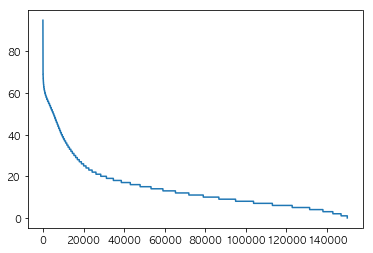

In [49]:
plt.plot(len_review) # 시퀀스의 최대길이는 60정도로 하면 될듯.

In [67]:
MAX_SEQUENCE_LENGTH = 60
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH) # MAX_SEQUENCE_LENGTH만큼 잘림.
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH) # MAX_SEQUENCE_LENGTH만큼 잘림.

In [71]:
X_train[:3]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,    86,
          532,     7,    31,   202,   127,   748],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,  1097,    12,   540,    62,   688,     2,   266,
           57,  1498,    41,  1257,   777,    38],
       [    0,     0,     0,     0,     0,    

## 3. CNN Modeling

### Embedding matrix 생성

In [72]:
EMBEDDING_DIM = 300

In [73]:
embedding_matrix = np.random.random((len(word2id)+1, EMBEDDING_DIM))
embedding_matrix # 랜덤값으로 초기화

array([[ 0.00700791,  0.35573502,  0.51139972, ...,  0.18719359,
         0.42934556,  0.68204269],
       [ 0.42230761,  0.9181581 ,  0.26944045, ...,  0.16361779,
         0.38475476,  0.13843139],
       [ 0.71813344,  0.27722144,  0.79266566, ...,  0.7891304 ,
         0.6024807 ,  0.1299213 ],
       ..., 
       [ 0.69003403,  0.17318001,  0.79312408, ...,  0.8637267 ,
         0.79911267,  0.90928977],
       [ 0.07474478,  0.15838595,  0.88857159, ...,  0.70022907,
         0.4349205 ,  0.51810644],
       [ 0.64345942,  0.4018112 ,  0.29217788, ...,  0.77330443,
         0.05750117,  0.01045013]])

In [74]:
embedding_matrix.shape

(55825, 300)

In [75]:
for k in word2id:
    embedding_matrix[word2id[k]] = w2v[k]

### Modeling

In [79]:
# create the model
DIC_SIZE = len(word2id)+1
model = Sequential()
model.add(Embedding(DIC_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=EMBEDDING_DIM, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(filters=EMBEDDING_DIM, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=EMBEDDING_DIM, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 300)           16747500  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 60, 300)           270300    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 12, 300)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 12, 300)           270300    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 300)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 4, 300)            270300    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 2, 300)            0         
__________

In [80]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=4096)

Train on 150000 samples, validate on 50000 samples
Epoch 1/5
150000/150000 [==============================] - 280s - loss: 0.6103 - acc: 0.6712 - val_loss: 0.5272 - val_acc: 0.8213

In [92]:
preds = model.predict_classes(X_test, batch_size=4096).reshape(-1)
actuals = np.array(y_test)

50000/50000 [==============================] - 26s     


In [93]:
# Accuracy
np.sum(np.array(actuals) == np.array(preds)) / float(len(actuals))

0.85226000000000002